## Productspace
In this Notebook we will show how to solve problems where our function is coming from a productspace. For example the Navier-Stokes equation where we solve for u $ \in [P^1]^3$ and p $ \in L^2$. The general structure will be very similar too the scalar case. As the productspace can be decomposed into the scalar spaces.

First we as always create a mesh

In [1]:
from import_hack import *
from methodsnm.mesh_4d import *
from methodsnm.visualize import *
import math
import numpy as np
from numpy import exp
from methodsnm.vectorspace import *
from methodsnm.fes import *
from netgen.csg import unit_cube
from ngsolve import Mesh,VOL,specialcf


source module for methodsNM imported.


In [2]:
m=2
T = 4
epsi = 0.1
ngmesh = Mesh(unit_cube.GenerateMesh(maxh=0.75))
mesh = UnstructuredHypertriangleMesh(T,ngmesh)

Let us take a closer look to the productspace and what it can and can not do.

In [3]:
V1 = P1_Hypertriangle_Space(mesh)
V2 = P1_Hypertriangle_Space(mesh)
V3 = P1_Hypertriangle_Space(mesh)
Q = P1_Hypertriangle_Space(mesh)
Fes = Productspace([V1,V2,V3,Q])
print("Anzahl an dofs" , Fes.ndof)
print("Anzahl an Elementen", Fes.ne)

Anzahl an dofs 180
Anzahl an Elementen 768


Some sanity check if it our fes does the right thinks. And as you can see the information about the Spaces itself is saved.

In [4]:
elnr = 0

# Spaces
Vx = Fes.spaces[0]
Vy = Fes.spaces[1]
Vz = Fes.spaces[2]
P  = Fes.spaces[3]

fe_vx = Vx.finite_element(elnr)
fe_p  = P.finite_element(elnr)

print("fe_vx.ndof:", fe_vx.ndof)
print("fe_p.ndof :", fe_p.ndof)

fe_block = Fes.finite_element(elnr)
print("block_ndofs:", fe_block.block_ndofs)
print("block_offsets:", fe_block.block_offsets)
fe = Vx.finite_element(0)
ips = np.array([[0.1,0.2,0.3,0.4]])

print("shape:", fe.evaluate(ips).shape)
print("shape deriv:", fe.evaluate(ips, deriv=True).shape)
pts_fes = V1.mesh.points
print(pts_fes.shape)
print(pts_fes[:10])

fe_vx.ndof: 5
fe_p.ndof : 5
block_ndofs: [5, 5, 5, 5]
block_offsets: [0, 5, 10, 15, 20]
shape: (1, 5)
shape deriv: (1, 4, 5)
(45, 4)
[[0.   0.   0.   0.  ]
 [0.   0.   1.   0.  ]
 [1.   0.   0.   0.  ]
 [0.   1.   0.   0.  ]
 [1.   0.   1.   0.  ]
 [0.   1.   1.   0.  ]
 [1.   1.   0.   0.  ]
 [1.   1.   1.   0.  ]
 [0.5  0.5  0.5  0.  ]
 [0.   0.   0.   0.25]]


In [5]:
def list_diff(a, b):
    """Entfernt alle Elemente aus Liste a, die in Liste b enthalten sind."""
    return [x for x in a if x not in b]
top = mesh.top_bndry_vertices
initial = mesh.initial_bndry_vertices
bndry = list_diff(mesh.bndry_vertices, top)
freedofs = list_diff(mesh.vertices,bndry)

Now we are going to solve the linearised Navier–Stokes equations in space–time.  
The strong form of the system is

$$
\partial_t u - \varepsilon \Delta u + (w \cdot \nabla) u - \nabla p = f,
$$

with the incompressibility constraint

$$
\nabla \cdot u = 0.
$$

---

## Weak formulation

We multiply the momentum equation by a test function $v$ and the divergence condition by a test function $q$.  
Integrating over the space–time domain $\Omega \times [0,T]$ and applying integration by parts yields the weak formulation:

Find $(u,p)$ such that for all $(v,q)$,

$$
\int_{\Omega \times [0,T]} 
\left( 
\partial_t u \cdot v
+ \varepsilon \nabla u : \nabla v
+ (w \cdot \nabla u) \cdot v
- p\, \nabla \cdot v
\right)\, dx\,dt
=
\int_{\Omega \times [0,T]} f \cdot v \, dx\,dt,
$$

and

$$
\int_{\Omega \times [0,T]} (\nabla \cdot u)\, q\, dx\,dt = 0.
$$

---

## Analytical solution

We consider the exact solution

$$
u_1(x,t) = e^{-t}\,\sin(\pi x)\cos(\pi y)\cos(\pi z),
$$

$$
u_2(x,t) = -e^{-t}\,\cos(\pi x)\sin(\pi y)\cos(\pi z),
$$

$$
u_3(x,t) = 0,
$$

with pressure

$$
p(x,t) = 0.
$$

This velocity field is divergence–free and satisfies the linearised Navier–Stokes equations with the corresponding forcing term $f = (f_1,f_2,f_3)$.

---

## Forcing term

Given viscosity $\nu$ and constant convection field $w = (w_x, w_y, w_z)$, the forcing components are

```python
f1 = lambda x: np.exp(-x[3]) * (
    (-1.0 + 3.0 * (np.pi**2) * nu) * np.sin(np.pi * x[0]) * np.cos(np.pi * x[1]) * np.cos(np.pi * x[2])
    + np.pi * wx * np.cos(np.pi * x[0]) * np.cos(np.pi * x[1]) * np.cos(np.pi * x[2])
    - np.pi * wy * np.sin(np.pi * x[0]) * np.sin(np.pi * x[1]) * np.cos(np.pi * x[2])
    - np.pi * wz * np.sin(np.pi * x[0]) * np.cos(np.pi * x[1]) * np.sin(np.pi * x[2])
)

f2 = lambda x: -np.exp(-x[3]) * (
    (1.0 - 3.0 * (np.pi**2) * nu) * np.sin(np.pi * x[1]) * np.cos(np.pi * x[0]) * np.cos(np.pi * x[2])
    + np.pi * wx * np.sin(np.pi * x[0]) * np.sin(np.pi * x[1]) * np.cos(np.pi * x[2])
    - np.pi * wy * np.cos(np.pi * x[0]) * np.cos(np.pi * x[1]) * np.cos(np.pi * x[2])
    + np.pi * wz * np.sin(np.pi * x[1]) * np.sin(np.pi * x[2]) * np.cos(np.pi * x[0])
)

f3 = lambda x: 0.0


To implement the mixed system, we assemble the block‐structured bilinear form.  
The finite element space is a product space consisting of three velocity components  
and one pressure component. Each block corresponds to an interaction between two fields  
(e.g. $u_i$ with $u_j$, or $u$ with $p$).

The call  
```python
BF.add_block_integrator(i, j, Integrator())


In [6]:
nu = 1
wx, wy, wz = 1, 1, 1
NU = GlobalFunction(lambda x: nu, mesh = mesh)
w = ConstantVectorFunction(np.array([wx,wy,wz,1]), mesh = mesh)

uex1 = lambda x: np.exp(-x[3]) * np.sin(np.pi * x[0]) * np.cos(np.pi * x[1]) * np.cos(np.pi * x[2])
uex2 = lambda x: -np.exp(-x[3]) * np.cos(np.pi * x[0]) * np.sin(np.pi * x[1]) * np.cos(np.pi * x[2])
uex3 = lambda x: 0.0
#pex  = lambda x: np.exp(-x[3]) * np.sin(np.pi * x[0]) * np.sin(np.pi * x[1]) * np.sin(np.pi * x[2])
pex  = lambda x: 0.0
f1 = lambda x: np.exp(-x[3]) * (
    (-1.0 + 3.0 * (np.pi**2) * nu) * np.sin(np.pi * x[0]) * np.cos(np.pi * x[1]) * np.cos(np.pi * x[2])
    + np.pi * wx * np.cos(np.pi * x[0]) * np.cos(np.pi * x[1]) * np.cos(np.pi * x[2])
    - np.pi * wy * np.sin(np.pi * x[0]) * np.sin(np.pi * x[1]) * np.cos(np.pi * x[2])
    - np.pi * wz * np.sin(np.pi * x[0]) * np.cos(np.pi * x[1]) * np.sin(np.pi * x[2])
    #- np.pi * np.sin(np.pi * x[1]) * np.sin(np.pi * x[2]) * np.cos(np.pi * x[0])   # <--- Vorzeichen gedreht
)

f2 = lambda x: -np.exp(-x[3]) * (
    (1.0 - 3.0 * (np.pi**2) * nu) * np.sin(np.pi * x[1]) * np.cos(np.pi * x[0]) * np.cos(np.pi * x[2])
    + np.pi * wx * np.sin(np.pi * x[0]) * np.sin(np.pi * x[1]) * np.cos(np.pi * x[2])
    - np.pi * wy * np.cos(np.pi * x[0]) * np.cos(np.pi * x[1]) * np.cos(np.pi * x[2])
    + np.pi * wz * np.sin(np.pi * x[1]) * np.sin(np.pi * x[2]) * np.cos(np.pi * x[0])
    #- np.pi * np.sin(np.pi * x[0]) * np.sin(np.pi * x[2]) * np.cos(np.pi * x[1])   # <--- Vorzeichen gedreht
)

f3 = lambda x: 0.0
#-np.exp(-x[3]) * (
#    -np.pi * np.sin(np.pi * x[0]) * np.sin(np.pi * x[1]) * np.cos(np.pi * x[2])   # <--- Vorzeichen gedreht
#)
g = lambda x: 0.0

fx = GlobalFunction(f1, mesh = mesh)
fy = GlobalFunction(f2, mesh = mesh)
fz = GlobalFunction(f3, mesh = mesh)
g = GlobalFunction(g, mesh = mesh)

from methodsnm.formint import *
from methodsnm.forms import *

BF = BilinearVectorForm(Fes)
# Diffusion (für x,y,z)
for b in range(3):
    BF.add_block_integrator(b, b, LaplaceIntegral_without_time(NU))
    BF.add_block_integrator(b, b, ConvectionIntegral(w))
for b in range(3):
    BF.add_block_integrator(3, b, DivUQIntegrator())
    BF.add_block_integrator(b, 3, DivVPIntegrator())
BF.add_block_integrator(3,3,PressureStabilizationIntegral(1))
BF.assemble()

LF = LinearVectorForm(Fes)
LF.add_block_integrator(0, SourceIntegral(fx))
LF.add_block_integrator(1, SourceIntegral(fy))
LF.add_block_integrator(2, SourceIntegral(fz))
LF.add_block_integrator(3, SourceIntegral(g))
LF.assemble()

u = FEVectorFunction(Fes)
u._set({0: (uex1,bndry), 1: (uex2,bndry), 2: (uex3,bndry)})
res = LF.vector - BF.matrix.dot(u.vector)
freedofs_global = Fes.get_freedofs({0: bndry, 1: bndry, 2: bndry})
from methodsnm.solver import solve_on_freedofs
u.vector += solve_on_freedofs(BF.matrix,res,freedofs_global)
u1 , u2, u3 , p = u.blocks()


from methodsnm.forms import compute_difference_L2
u_ex1 = GlobalFunction(uex1, mesh = mesh)
u_ex2 = GlobalFunction(uex2, mesh = mesh)
u_ex3 = GlobalFunction(uex3, mesh = mesh)
l2diff = compute_difference_L2(u1, u_ex1, mesh, intorder = 5)
l2diff += compute_difference_L2(u2, u_ex2, mesh, intorder = 5)
l2diff += compute_difference_L2(u3, u_ex3, mesh, intorder = 5)
print("L2 difference:", l2diff)

L2 difference: 0.4780505788873397


In [7]:
print(freedofs)

[17, 26, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44]


### Analysing Bilinear matrix 


shape: (180, 180)
nnz  : 6146


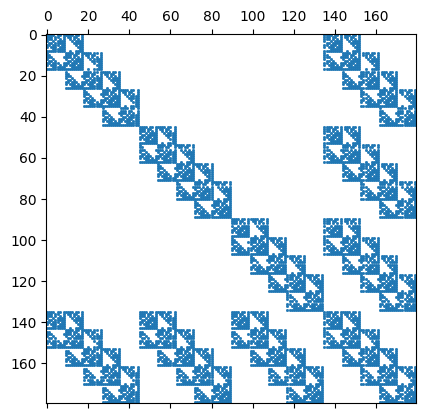

In [8]:
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
K = BF.matrix
# Beispiel: K ist deine globale Matrix
# K: csr_matrix

# 1) Indizes der Nichtnull-Einträge
rows, cols = K.nonzero()      # arrays mit Zeilen- / Spaltenindizes
nnz = K.nnz                    # Anzahl Nichtnull-Einträge

print("shape:", K.shape)
print("nnz  :", nnz)

# 2) Sparsity-Plot
plt.figure()
plt.spy(K, markersize=1)
plt.show()


In [9]:
from methodsnm.visualize_4d_function import interactive_u_abs,interactive_u_component
import PyQt5
import pyvista as pv
pv.OFF_SCREEN
#interactive_u_component(u, comp=1, t_min=0, t_max=1, samples=5)

False

/home/matilda/.local/lib/python3.8/site-packages/pyvista/jupyter/notebook.py:37: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/home/matilda/.local/lib/python3.8/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


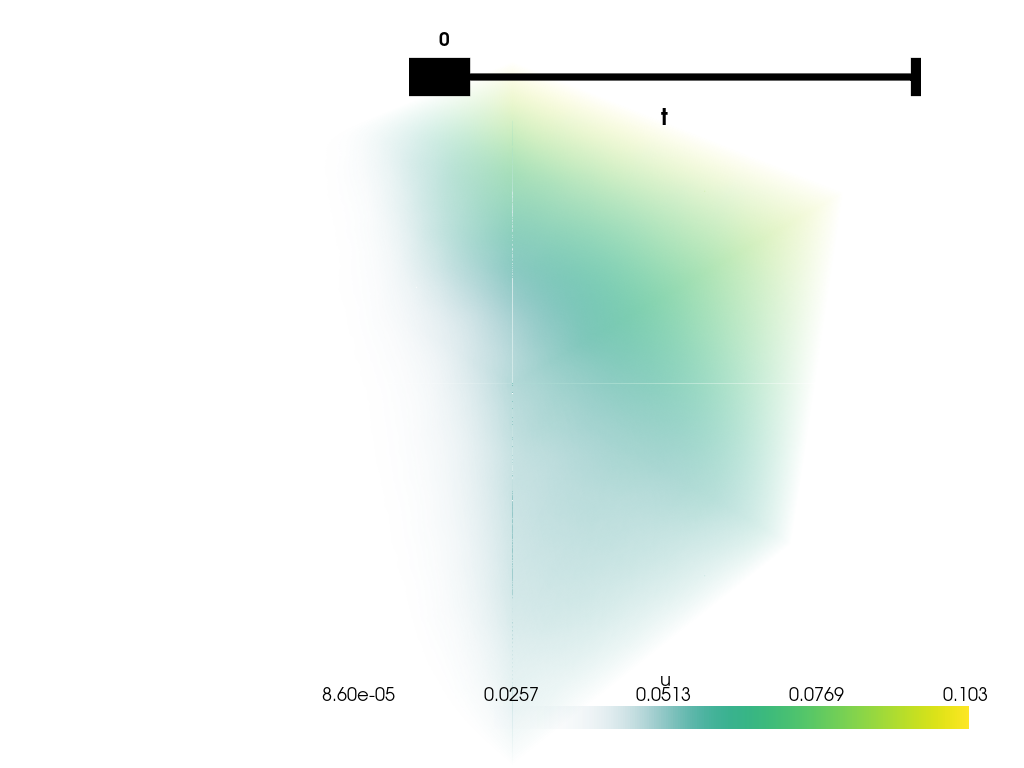

In [10]:
interactive_u_abs(u, t_min=0, t_max=1, samples=5)